In [ ]:
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch import nn
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
from time import sleep
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# train_cols = ["ISOR", "CAPE", "TCWV", "TCC", "TCW", "B14B", "B12B", "B09B",
#              "WVB", "I4B", "B10B", "B11B", "B16B", "I2B", "IRB"]
train_cols = ["ISOR", "CAPE", "TCWV", "TCC", "TCW", "IRB", "B10B", "B16B", "B11B", "I2B", "WVB", "B09B"]
class RainDataset(Dataset):
    def __init__(self, img_dirs_file):
        self.df = pd.read_csv(img_dirs_file, skiprows=[249])
        self.img_dirs = self.df[train_cols]
        self.gt_dirs = self.df["radar"]

    def __len__(self):
        return len(self.img_dirs)

    def __getitem__(self, i):
        raw_input = []
        # print(i)
        for j in range(len(self.img_dirs.loc[i])):
            # print(j)
            raw_input.append(self.get_tensor(self.img_dirs.loc[i][j]))
        input = []
        for j in range(5):
           input.append(raw_input[j])
        input.append(raw_input[train_cols.index("IRB")])
        input.append(torch.sub(raw_input[train_cols.index("B10B")], raw_input[train_cols.index("B16B")]))
        input.append(torch.sub(raw_input[train_cols.index("B11B")], raw_input[train_cols.index("IRB")]))
        input.append(torch.sub(raw_input[train_cols.index("IRB")], raw_input[train_cols.index("I2B")]))
        input.append(torch.sub(raw_input[train_cols.index("WVB")], raw_input[train_cols.index("B09B")]))
        input.append(torch.sub(raw_input[train_cols.index("B09B")], raw_input[train_cols.index("B10B")]))
        input = torch.stack((input))
        gt = self.get_tensor(self.gt_dirs[i]).reshape(1, 512, 512)
        gt_cls = torch.where(gt > 0, 1, 0)
        return input, gt_cls
    
    def get_tensor(self, path):
        img = gdal.Open(path)
        img_arr = img.GetRasterBand(1).ReadAsArray()
        img_tensor = torch.from_numpy(img_arr)
        return img_tensor

In [ ]:
dataset = RainDataset("/content/drive/MyDrive/Dataset3/sampling.csv")

In [ ]:
len(dataset)

263

In [ ]:
from torch.utils.data.dataset import random_split

def split_train_val_test(dataset, val_ratio=0.1, test_ratio=0.2):
    test_length = int(len(dataset) * test_ratio)
    val_length = int(len(dataset) * val_ratio)
    train_length = len(dataset) - val_length - test_length
    return random_split(
        dataset, lengths=[train_length, val_length, test_length]
    )
j
np.random.seed(0)
torch.manual_seed(0)

train_ds, val_ds, test_ds = split_train_val_test(dataset)

In [ ]:
len(train_ds)

185

In [ ]:
for x, y in train_ds:
  print(x.shape)
  break

torch.Size([11, 512, 512])


In [ ]:
class Unet(nn.Module):
  def __init__(self, in_channels=11, n_classes=1, filters=[64, 128, 256, 512, 1024], is_batchnorm=True, is_deconv=True):
    super(Unet, self).__init__()
    # downsampling
    self.conv1 = Conv(in_channels, filters[0], is_batchnorm)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.conv2 = Conv(filters[0], filters[1], is_batchnorm)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.conv3 = Conv(filters[1], filters[2], is_batchnorm)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    self.conv4 = Conv(filters[2], filters[3], is_batchnorm)
    self.maxpool4 = nn.MaxPool2d(kernel_size=2)

    self.center = Conv(filters[3], filters[4], is_batchnorm)

    # upsampling
    self.up_concat4 = UpConv(filters[4], filters[3], is_batchnorm)
    self.up_concat3 = UpConv(filters[3], filters[2], is_batchnorm)
    self.up_concat2 = UpConv(filters[2], filters[1], is_batchnorm)
    self.up_concat1 = UpConv(filters[1], filters[0], is_batchnorm)

    # final
    self.final = nn.Conv2d(filters[0], n_classes, 1, stride=(1, 1))

  def forward(self, input):
    conv1 = self.conv1(input)
    maxpool1 = self.maxpool1(conv1)

    conv2 = self.conv2(maxpool1)
    maxpool2 = self.maxpool2(conv2)

    conv3 = self.conv3(maxpool2)
    maxpool3 = self.maxpool3(conv3)

    conv4 = self.conv4(maxpool3)
    maxpool4 = self.maxpool4(conv4)

    center = self.center(maxpool4)
    up4 = self.up_concat4(conv4, center)
    up3 = self.up_concat3(conv3, up4)
    up2 = self.up_concat2(conv2, up3)
    up1 = self.up_concat1(conv1, up2)

    final = self.final(up1)

    return final

In [ ]:
class ResNet_Unet(nn.Module):
  def __init__(self, in_channels=11, n_classes=1, filters=[64, 64, 128, 256, 512, 1024], repeat=[3, 4, 6, 3], is_batchnorm=True, is_deconv=True):
    super(ResNet_Unet, self).__init__()
    # downsampling
    self.conv0 = nn.Sequential(
        nn.Conv2d(in_channels, filters[0], kernel_size=7, stride=1, padding=3),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(filters[0])
    )
    
    self.conv1 = nn.Sequential()
    self.conv1.add_module('conv1_1', ResBlock(filters[0], filters[1], downsample=False))
    for i in range(1, repeat[0]):
        self.conv1.add_module('conv1_%d'%(i + 1), ResBlock(filters[1], filters[1], downsample=False))

    self.conv2 = nn.Sequential()
    self.conv2.add_module('conv2_1', ResBlock(filters[1], filters[2], downsample=True))
    for i in range(1, repeat[1]):
        self.conv2.add_module('conv2_%d'%(i + 1), ResBlock(filters[2], filters[2], downsample=False))

    self.conv3 = nn.Sequential()
    self.conv3.add_module('conv3_1', ResBlock(filters[2], filters[3], downsample=True))
    for i in range(1, repeat[2]):
        self.conv3.add_module('conv3_%d'%(i + 1), ResBlock(filters[3], filters[3], downsample=False))

    self.conv4 = nn.Sequential()
    self.conv4.add_module('conv4_1', ResBlock(filters[3], filters[4], downsample=True))
    for i in range(1, repeat[3]):
        self.conv4.add_module('conv4_%d'%(i + 1), ResBlock(filters[4], filters[4], downsample=False))

    self.center = Conv(filters[4], filters[5], is_batchnorm)

    # upsampling
#     self.up_concat5 = UpConv(filters[5], filters[4], is_batchnorm)
    self.up_concat4 = UpConv(filters[5], filters[4], is_batchnorm)
    self.up_concat3 = UpConv(filters[4], filters[3], is_batchnorm)
    self.up_concat2 = UpConv(filters[3], filters[2], is_batchnorm)
    self.up_concat1 = UpConv(filters[2], filters[1], is_batchnorm)

    # final
    self.final = nn.Conv2d(filters[0], n_classes, 1, stride=1)

  def forward(self, input):
    conv0 = self.conv0(input)

    conv1 = self.conv1(conv0)

    conv2 = self.conv2(conv1)

    conv3 = self.conv3(conv2)

    conv4 = self.conv4(conv3)

    center = self.center(conv4)

    up4 = self.up_concat4(conv4, center)
    up3 = self.up_concat3(conv3, up4)
    up2 = self.up_concat2(conv2, up3)
    up1 = self.up_concat1(conv1, up2)

    final = self.final(up1)

    return final

In [ ]:
class Conv(nn.Module):
  def __init__(self, in_size, out_size, is_batchnorm=True, kernel_size=3, padding=1, stride=1):
    super(Conv, self).__init__()
    if (is_batchnorm):
      self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, stride, padding),
                                 nn.BatchNorm2d(out_size),
                                 nn.ReLU())
      self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, kernel_size, 1, padding),
                                 nn.BatchNorm2d(out_size),
                                 nn.ReLU())
    else:
      self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, stride, padding),
                                 nn.ReLU())
      self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, kernel_size, 1, padding),
                                 nn.ReLU())
      
  def forward(self, input):
    output = self.conv1(input)
    output = self.conv2(output)
    return output

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample=False):
        super(ResBlock, self).__init__()
        if (downsample):
            self.conv = Conv(in_size, out_size, stride=2)
            self.shortcut = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size=1, stride=2))
        else:
            self.conv = Conv(in_size, out_size)
            self.shortcut = nn.Sequential()
        
    def forward(self, input):
        shortcut = self.shortcut(input)
        output = self.conv(input)
        output = output + shortcut
        output = nn.ReLU()(output)
        return output

In [ ]:
class UpConv(nn.Module):
  def __init__(self, in_size, out_size, is_batchnorm=True, is_deconv=True, kernel_size=4, padding=1, stride=2):
    super(UpConv, self).__init__()
    if (is_deconv):
      self.conv = Conv(in_size, out_size, False)
      self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size, stride, padding)
      
  def forward(self, input1, input2):
    output2 = self.up(input2)
    offset = output2.size()[2] - input1.size()[2]
    padding = 2 * [offset // 2, offset // 2]
    output1 = F.pad(input1, padding)
    return self.conv(torch.cat([output1, output2], 1))

In [ ]:
class ResidualAttentionUNet(nn.Module):
  def __init__(self, inputChannel=11, outputChannel=1):
    super().__init__()
    self.downsample1 = DownSampleWithAttention(inputChannel, 32)
    self.downsample2 = DownSampleWithAttention(32, 64)
    self.downsample3 = DownSampleWithAttention(64, 128)
    self.downsample4 = DownSampleWithAttention(128, 256)
    self.downsample5 = DownSampleWithAttention(256, 512)

    self.residualBlock1 = ResidualBlock(512, 512)
    self.residualBlock2 = ResidualBlock(512, 512)
    self.residualBlock3 = ResidualBlock(512, 512)

    self.upsample1 = UpSampleWithAttention(512, 256)
    self.upsample2 = UpSampleWithAttention(512, 128)
    self.upsample3 = UpSampleWithAttention(256, 64)
    self.upsample4 = UpSampleWithAttention(128, 32)
    self.upsample5 = UpSampleWithAttention(64, 32)
    self.classification = nn.Sequential(
            nn.Conv2d(32, outputChannel, kernel_size=1),
        )

  def forward(self, x):
    scale128, sa128down = self.downsample1(x)
    scale64, sa64down = self.downsample2(scale128)
    scale32, sa32down = self.downsample3(scale64)
    scale16, sa64down = self.downsample4(scale32)
    scale8, sa8down = self.downsample5(scale16)
    scale8, sa8down = self.residualBlock1(scale8)
    scale8, sa8down = self.residualBlock2(scale8)
    scale8, sa8down = self.residualBlock3(scale8)
    upscale16, sa16up = self.upsample1(scale8)
    upscale16 = torch.cat([upscale16, scale16], dim=1)
    upscale32, sa32up = self.upsample2(upscale16)
    upscale32 = torch.cat([upscale32, scale32], dim=1)
    upscale64, sa64up = self.upsample3(upscale32)
    upscale64 = torch.cat([upscale64, scale64], dim=1)
    upscale128, sa128up = self.upsample4(upscale64)
    upscale128 = torch.cat([upscale128, scale128], dim=1)
    upscale256, sa256up = self.upsample5(upscale128)
    finaloutput = self.classification(upscale256)
    return finaloutput

class DownSampleWithAttention(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
    
    def forward(self,x):
        x = self.convolution(x)
        caOutput = self.ca(x)
        x = caOutput * x
        saOutput = self.sa(x)
        x = saOutput * x
        return x, saOutput

class ResidualBlock(nn.Module):
    def __init__(self, inputChannel, outputChannel, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(inputChannel, outputChannel, stride)
        self.bn1 = nn.BatchNorm2d(outputChannel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(outputChannel, outputChannel)
        self.bn2 = nn.BatchNorm2d(outputChannel)
        self.downsample = downsample
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        caOutput = self.ca(out)
        out = caOutput * out
        saOutput = self.sa(out)
        out = saOutput * out
        return out, saOutput

class UpSampleWithAttention(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
    
    def forward(self, x):
        x = self.upsample(x)
        x = self.convolution(x)
        caOutput = self.ca(x)
        x = caOutput * x
        saOutput = self.sa(x)
        x = saOutput * x
        return x, saOutput

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [ ]:
batch_size = 2
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# for img, label in train_dataloader:  
#     print(img)
#     print(label)
#     break

In [ ]:
def train_epoch(model, optimizer, train_dataloader):
    model.train()
    total_loss = 0
    correct = 0
    total_correct = 0

    with tqdm(train_dataloader, unit="batch") as epoch:
      for x, y in epoch:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        loss = loss_func(out.squeeze(1), y.squeeze(1).float())
        loss += dice_loss(torch.sigmoid(out.squeeze(1)), y.squeeze(1).float())

        pred = (out.squeeze(1) > 0.1).float()
        correct = (pred == y.squeeze(1)).sum().item()
        total_correct += correct
        batch_accuracy = round(correct / (batch_size * x.shape[2] * x.shape[3]), 4)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch.set_postfix(loss=loss.item(), accuracy=100. * batch_accuracy)
        sleep(0.1)

        total_loss += (loss.item())

    total_loss = round(total_loss/(len(train_dataloader)), 4)
    accuracy = round(total_correct / (len(train_ds) * x.shape[2] * x.shape[3]), 4)

    return accuracy, total_loss

def val_epoch(model, val_dataloader):
    model.eval()
#     total = len(val_ds) * x.shape[2] * x.shape[3]
    total_correct = 0 # count number of correct predictions on test set
    total_loss = 0
#     y_true, y_pred = [], []
    true_positive, false_positive, false_negative = 0, 0, 0

    with tqdm(val_dataloader, unit="batch") as epoch:
      for x, y in epoch:
        with torch.no_grad(): # prevent gradient computation
          x = x.to(device)
          y = y.to(device)
          out = model(x)
          loss = loss_func(out.squeeze(1), y.squeeze(1).float())
          loss += dice_loss(torch.sigmoid(out.squeeze(1)), y.squeeze(1).float())
          # take the maximum output
          # pred = (torch.sigmoid(out.squeeze(1)) > 0.5).float()
          pred = (out.squeeze(1) > 0.1).float()
#           pred = np.reshape(pred.cpu().numpy(), (pred.shape[0] * pred.shape[1] * pred.shape[2])).astype(int)
          target = y.squeeze(1)

          # count the correct predictions
          correct = (pred == target).sum().item()
          total_correct += correct
          batch_accuracy = round(correct / (batch_size * x.shape[2] * x.shape[3]), 4)
          total_loss += (loss.item())
          
          # precision, recall, f1-score
          tp = torch.logical_and(pred == 1, target == 1).sum().item()
          fp = torch.logical_and(pred == 1, target == 0).sum().item()
#           tn = torch.logical_and(pred == 0, target == 0).sum().item()
          fn = torch.logical_and(pred == 0, target == 1).sum().item()
        
          true_positive += tp
          false_positive += fp
#           true_negative += tn
          false_negative += fn

          epoch.set_postfix(loss=loss.item(), accuracy=100. * batch_accuracy)
          sleep(0.1)
            
    total_loss = round(total_loss / len(val_dataloader), 4)

    # compute test accuracy for this epoch
    accuracy = round(total_correct / (len(val_ds) * x.shape[2] * x.shape[3]), 4)
    
    # compute classification report for this epoch
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = (2 * precision * recall) / (precision + recall)
    
    print("  *** Validation Result ***")
    print(f"  Precision: {format(precision, '.4f')}      Recall: {format(recall, '.4f')}      F1-score: {format(f1, '.4f')}")
    
    return accuracy, total_loss

def test(model, test_dataloader):
  # calculate prediction on test set
  total_correct = 0
  true_positive, false_positive, false_negative = 0, 0, 0
  y_true, y_pred = [], []

  model.eval()
  with tqdm(test_dataloader, unit="batch") as tepoch:
    for x, y in tepoch:
      with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        pred = (out.squeeze(1) > 0.1).float()
        target = y.squeeze(1)
        y_true.append(target)
        y_pred.append(pred)

        correct = (pred == y.squeeze(1)).sum().item()
        batch_accuracy = round(correct / (batch_size * x.shape[2] * x.shape[3]), 4)
        total_correct += correct
        
        tp = torch.logical_and(pred == 1, target == 1).sum().item()
        fp = torch.logical_and(pred == 1, target == 0).sum().item()
        fn = torch.logical_and(pred == 0, target == 1).sum().item()
        
        true_positive += tp
        false_positive += fp
        false_negative += fn
    
        tepoch.set_postfix(accuracy=100. * batch_accuracy)
        sleep(0.1)

  accuracy = round(total_correct/(len(test_ds) * x.shape[2] * x.shape[3]), 4)
  
  precision = true_positive / (true_positive + false_positive)
  recall = true_positive / (true_positive + false_negative)
  f1 = (2 * precision * recall) / (precision + recall)

  print("  *** Test Result ***")
  print(f"  Precision: {format(precision, '.4f')}      Recall: {format(recall, '.4f')}      F1-score: {format(f1, '.4f')}")
  print(f"  Accuracy: {format(accuracy, '.4f')}")

  return y_true, y_pred

In [ ]:
model_save_name = 'cls_model_resatt_hima_full.pt'
path = F"/content/drive/MyDrive/model/{model_save_name}" 
def save_model(model):
  torch.save(model.state_dict(), path)

In [ ]:
model = ResidualAttentionUNet()
# model.load_state_dict(torch.load(F"/content/drive/MyDrive/model/{model_save_name}"))
loss_func = nn.BCEWithLogitsLoss()
arr_lr = [0.1, 0.01, 0.001, 1e-4, 5e-4]
lr = arr_lr[4]
optimizer = torch.optim.Adam(model.parameters(), lr)

In [ ]:
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    sum_dim = (-1, -2, -3)
    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

def dice_loss(input, target):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - dice_coeff(input, target, reduce_batch_first=True)

In [ ]:
n_epoch = 5
arr_n_epoch = [30]

train_acc = []
val_acc = []
train_losses = []
val_losses = []

best_model = model
best_acc = 0

img_width = 512
img_height = 512

for n_ep in arr_n_epoch:
  print('-' * 50)
  print(f'Number of epoch: {n_ep} \nLearning rate: {lr} -- Batch size: {batch_size} -- Optimizer: Adam')
  n_epoch = n_ep
  model.to(device)

  for epoch in range(n_epoch):

    print(f"Epoch {epoch + 1} started")
    
    train_accuracy, train_loss = train_epoch(model, optimizer, train_dataloader)
    val_accuracy, val_loss = val_epoch(model, val_dataloader)

    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    

    if (val_accuracy > best_acc):
      best_model = model
      best_acc = val_accuracy
      save_model(best_model)

    print(f"  Train Accuracy     : {format(train_accuracy, '.4f')}   Train Loss     : {format(train_loss, '.4f')}")
    print(f"  Validation Accuracy: {format(val_accuracy, '.4f')}   Validation Loss: {format(val_loss, '.4f')}")    

--------------------------------------------------
Number of epoch: 30 
Learning rate: 0.0005 -- Batch size: 2 -- Optimizer: Adam
Epoch 1 started


100%|██████████| 13/13 [00:04<00:00,  2.64batch/s, accuracy=83.1, loss=0.7]


  *** Validation Result ***
  Precision: 0.7956      Recall: 0.7815      F1-score: 0.7885
  Train Accuracy     : 0.9308   Train Loss     : 0.3626
  Validation Accuracy: 0.8930   Validation Loss: 0.5432
Epoch 2 started


100%|██████████| 13/13 [00:05<00:00,  2.44batch/s, accuracy=81.9, loss=0.77]


  *** Validation Result ***
  Precision: 0.8212      Recall: 0.7450      F1-score: 0.7812
  Train Accuracy     : 0.9319   Train Loss     : 0.3549
  Validation Accuracy: 0.8936   Validation Loss: 0.5582
Epoch 3 started


100%|██████████| 13/13 [00:05<00:00,  2.48batch/s, accuracy=80, loss=0.803]


  *** Validation Result ***
  Precision: 0.8157      Recall: 0.7412      F1-score: 0.7767
  Train Accuracy     : 0.9329   Train Loss     : 0.3491
  Validation Accuracy: 0.8912   Validation Loss: 0.5656
Epoch 4 started


100%|██████████| 13/13 [00:05<00:00,  2.37batch/s, accuracy=81.6, loss=0.769]


  *** Validation Result ***
  Precision: 0.7875      Recall: 0.7990      F1-score: 0.7932
  Train Accuracy     : 0.9325   Train Loss     : 0.3510
  Validation Accuracy: 0.8937   Validation Loss: 0.5447
Epoch 5 started


100%|██████████| 13/13 [00:05<00:00,  2.37batch/s, accuracy=81.7, loss=0.766]


  *** Validation Result ***
  Precision: 0.8349      Recall: 0.7231      F1-score: 0.7750
  Train Accuracy     : 0.9325   Train Loss     : 0.3500
  Validation Accuracy: 0.8929   Validation Loss: 0.5562
Epoch 6 started


100%|██████████| 13/13 [00:05<00:00,  2.38batch/s, accuracy=82.2, loss=0.737]


  *** Validation Result ***
  Precision: 0.7536      Recall: 0.8317      F1-score: 0.7907
  Train Accuracy     : 0.9341   Train Loss     : 0.3423
  Validation Accuracy: 0.8877   Validation Loss: 0.5512
Epoch 7 started


100%|██████████| 13/13 [00:05<00:00,  2.47batch/s, accuracy=80, loss=0.8]


  *** Validation Result ***
  Precision: 0.7772      Recall: 0.7885      F1-score: 0.7828
  Train Accuracy     : 0.9333   Train Loss     : 0.3455
  Validation Accuracy: 0.8884   Validation Loss: 0.5522
Epoch 8 started


100%|██████████| 13/13 [00:05<00:00,  2.49batch/s, accuracy=82.5, loss=0.699]


  *** Validation Result ***
  Precision: 0.7902      Recall: 0.7987      F1-score: 0.7944
  Train Accuracy     : 0.9349   Train Loss     : 0.3387
  Validation Accuracy: 0.8945   Validation Loss: 0.5293
Epoch 9 started


100%|██████████| 13/13 [00:05<00:00,  2.57batch/s, accuracy=81.2, loss=0.734]


  *** Validation Result ***
  Precision: 0.7867      Recall: 0.8158      F1-score: 0.8010
  Train Accuracy     : 0.9365   Train Loss     : 0.3292
  Validation Accuracy: 0.8966   Validation Loss: 0.5187
Epoch 10 started


100%|██████████| 13/13 [00:04<00:00,  2.61batch/s, accuracy=80.9, loss=0.814]


  *** Validation Result ***
  Precision: 0.8495      Recall: 0.6947      F1-score: 0.7644
  Train Accuracy     : 0.9348   Train Loss     : 0.3377
  Validation Accuracy: 0.8907   Validation Loss: 0.5746
Epoch 11 started


100%|██████████| 13/13 [00:04<00:00,  2.61batch/s, accuracy=82.3, loss=0.717]


  *** Validation Result ***
  Precision: 0.8107      Recall: 0.7860      F1-score: 0.7981
  Train Accuracy     : 0.9362   Train Loss     : 0.3306
  Validation Accuracy: 0.8986   Validation Loss: 0.5225
Epoch 12 started


100%|██████████| 13/13 [00:05<00:00,  2.60batch/s, accuracy=82.1, loss=0.763]


  *** Validation Result ***
  Precision: 0.8378      Recall: 0.7334      F1-score: 0.7821
  Train Accuracy     : 0.9387   Train Loss     : 0.3197
  Validation Accuracy: 0.8957   Validation Loss: 0.5479
Epoch 13 started


100%|██████████| 13/13 [00:04<00:00,  2.61batch/s, accuracy=83.2, loss=0.698]


  *** Validation Result ***
  Precision: 0.7941      Recall: 0.7725      F1-score: 0.7831
  Train Accuracy     : 0.9389   Train Loss     : 0.3200
  Validation Accuracy: 0.8908   Validation Loss: 0.5470
Epoch 14 started


100%|██████████| 13/13 [00:04<00:00,  2.62batch/s, accuracy=81, loss=0.779]


  *** Validation Result ***
  Precision: 0.8306      Recall: 0.7370      F1-score: 0.7810
  Train Accuracy     : 0.9377   Train Loss     : 0.3244
  Validation Accuracy: 0.8946   Validation Loss: 0.5471
Epoch 15 started


100%|██████████| 13/13 [00:05<00:00,  2.44batch/s, accuracy=80.8, loss=0.778]


  *** Validation Result ***
  Precision: 0.8099      Recall: 0.7669      F1-score: 0.7878
  Train Accuracy     : 0.9394   Train Loss     : 0.3140
  Validation Accuracy: 0.8946   Validation Loss: 0.5372
Epoch 16 started


100%|██████████| 13/13 [00:05<00:00,  2.39batch/s, accuracy=81.2, loss=0.764]


  *** Validation Result ***
  Precision: 0.7992      Recall: 0.7915      F1-score: 0.7953
  Train Accuracy     : 0.9405   Train Loss     : 0.3076
  Validation Accuracy: 0.8961   Validation Loss: 0.5284
Epoch 17 started


100%|██████████| 13/13 [00:05<00:00,  2.38batch/s, accuracy=81.7, loss=0.776]


  *** Validation Result ***
  Precision: 0.8290      Recall: 0.7486      F1-score: 0.7867
  Train Accuracy     : 0.9407   Train Loss     : 0.3092
  Validation Accuracy: 0.8965   Validation Loss: 0.5477
Epoch 18 started


100%|██████████| 13/13 [00:05<00:00,  2.36batch/s, accuracy=80.4, loss=0.841]


  *** Validation Result ***
  Precision: 0.7848      Recall: 0.8073      F1-score: 0.7959
  Train Accuracy     : 0.9411   Train Loss     : 0.3042
  Validation Accuracy: 0.8944   Validation Loss: 0.5490
Epoch 19 started


100%|██████████| 13/13 [00:05<00:00,  2.41batch/s, accuracy=81.8, loss=0.738]


  *** Validation Result ***
  Precision: 0.8113      Recall: 0.7795      F1-score: 0.7950
  Train Accuracy     : 0.9419   Train Loss     : 0.3021
  Validation Accuracy: 0.8975   Validation Loss: 0.5260
Epoch 20 started


100%|██████████| 13/13 [00:05<00:00,  2.43batch/s, accuracy=82.7, loss=0.721]


  *** Validation Result ***
  Precision: 0.8327      Recall: 0.7548      F1-score: 0.7918
  Train Accuracy     : 0.9424   Train Loss     : 0.3001
  Validation Accuracy: 0.8987   Validation Loss: 0.5328
Epoch 21 started


  2%|▏         | 2/93 [00:01<01:08,  1.33batch/s, accuracy=95.6, loss=0.259]


KeyboardInterrupt: ignored

In [ ]:
best_acc

0.8987

In [ ]:
best_model.to(device)
target, pred = test(best_model, test_dataloader)

100%|██████████| 26/26 [00:10<00:00,  2.46batch/s, accuracy=87.9]

  *** Test Result ***
  Precision: 0.8259      Recall: 0.7436      F1-score: 0.7826
  Accuracy: 0.8880


In [ ]:
import torchvision.transforms as T

def tensor_to_img(tensor):
  transform = T.ToPILImage()
  # convert the tensor to PIL image using above transform
  img = transform(tensor)
  return img

In [ ]:
def plot(target_img, pred_img):
  fig = plt.figure(figsize=(15, 15))

  fig.add_subplot(3, 2, 1)
  
  # showing image
  plt.imshow(target_img, cmap='gray')
  plt.axis('off')
  plt.title("Label")
    
  # Adds a subplot at the 2nd position
  fig.add_subplot(3, 2, 2)
    
  # showing image
  plt.imshow(pred_img, cmap='gray')
  plt.axis('off')
  plt.title("Predict")

<ipython-input-91-671c82ddb9f3>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15, 15))


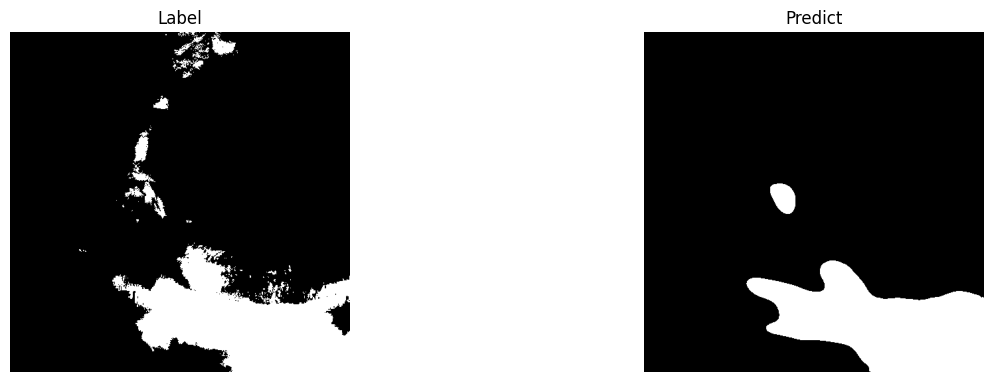

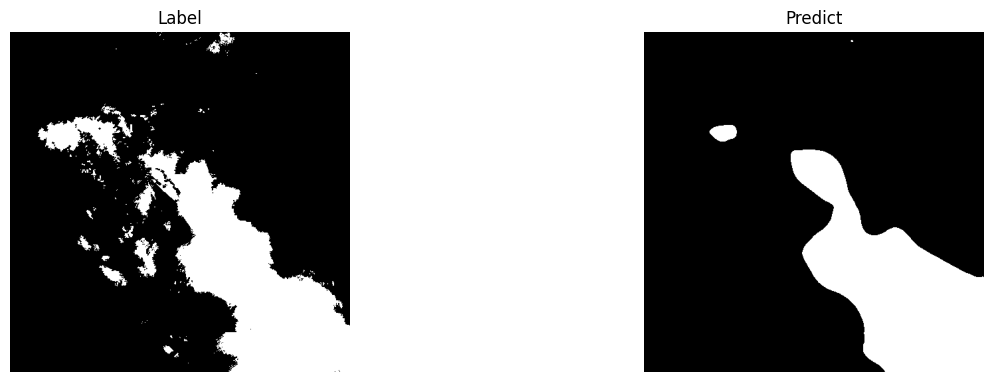

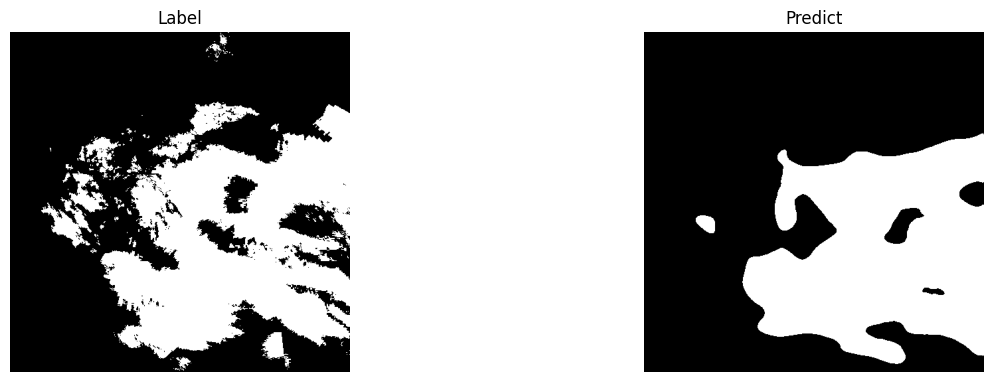

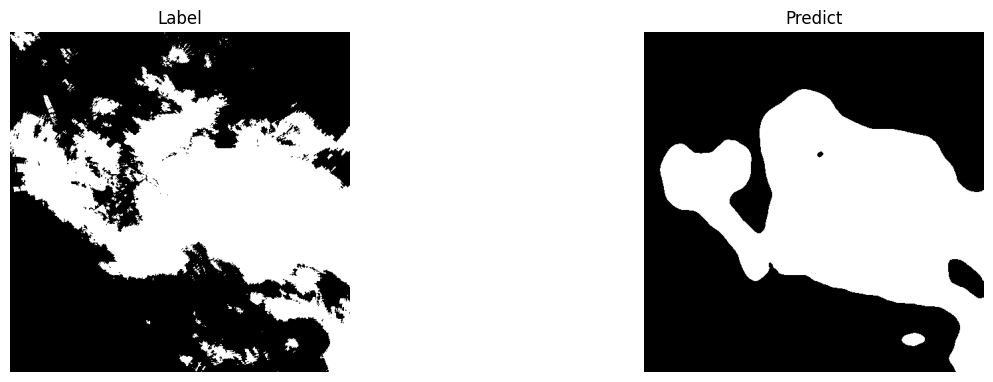

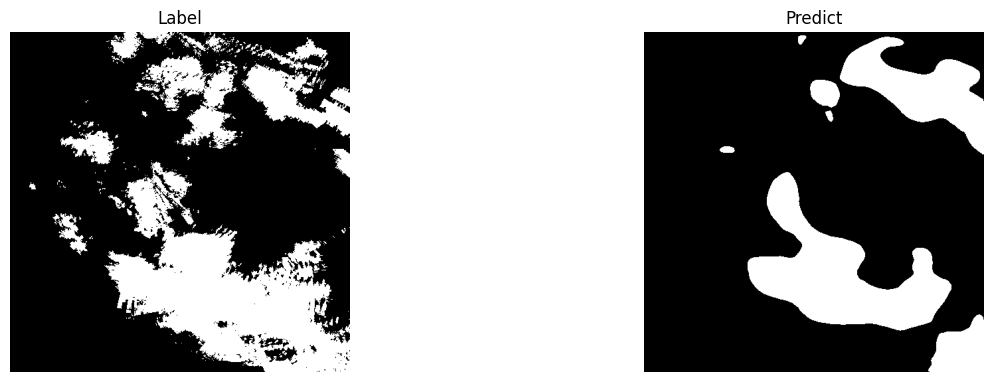

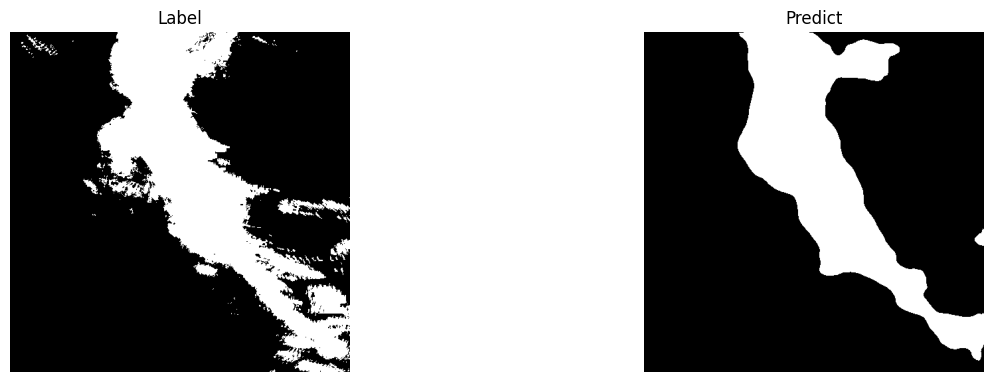

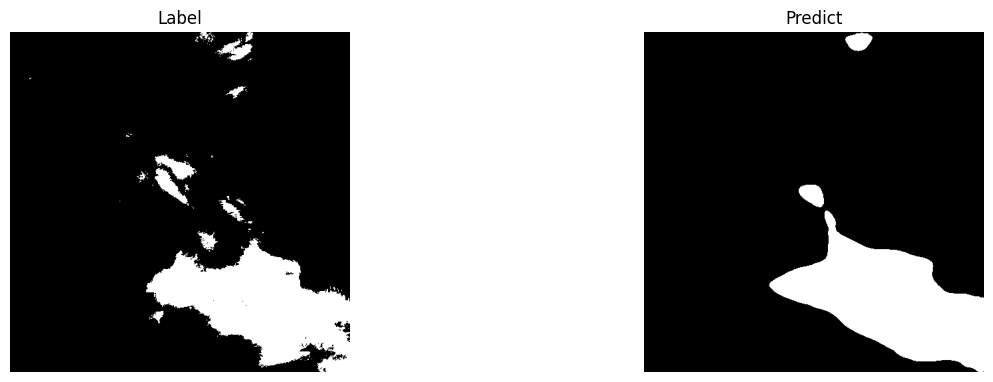

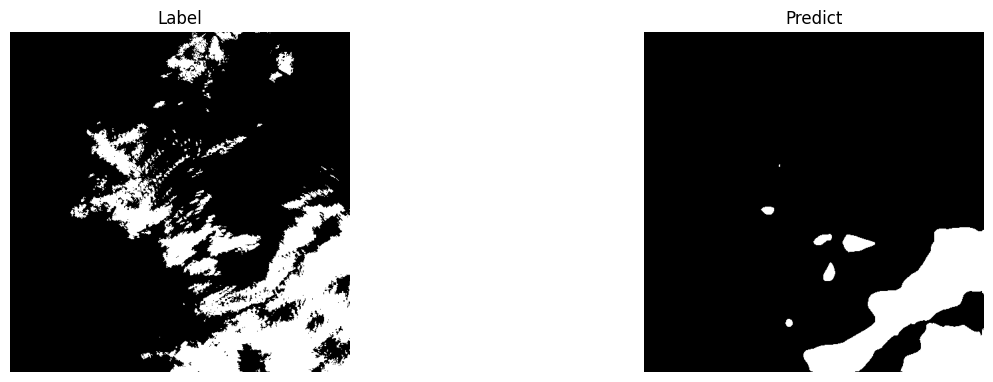

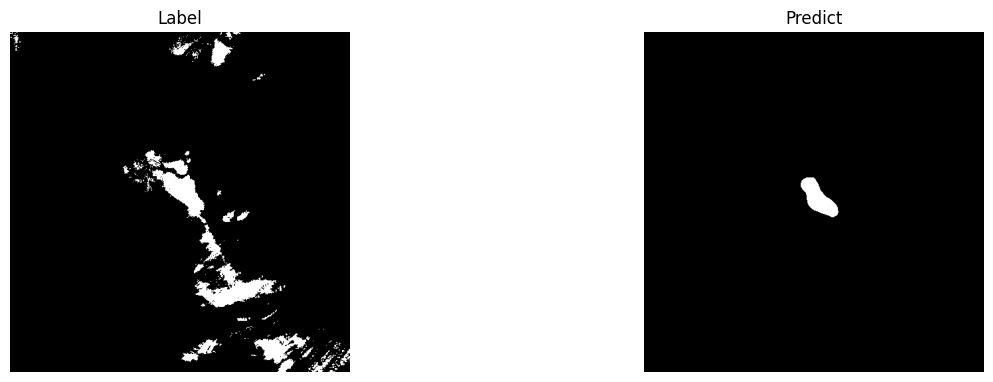

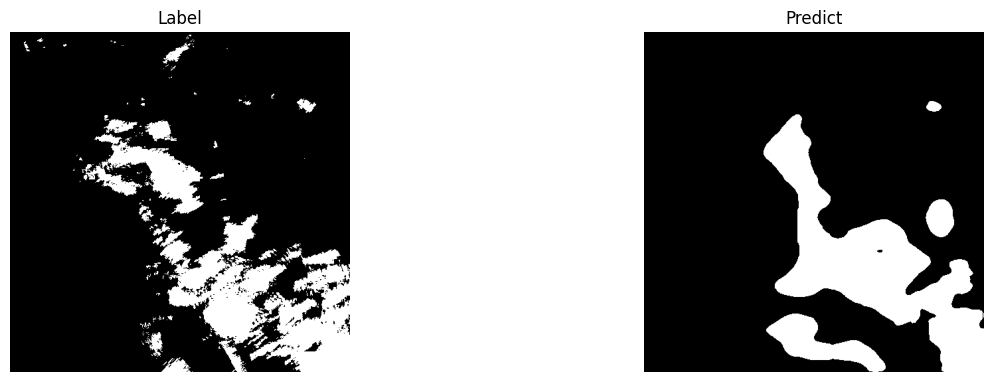

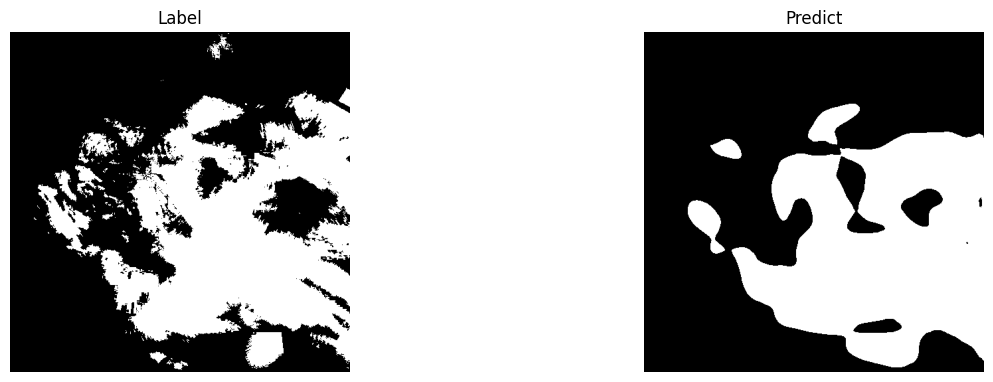

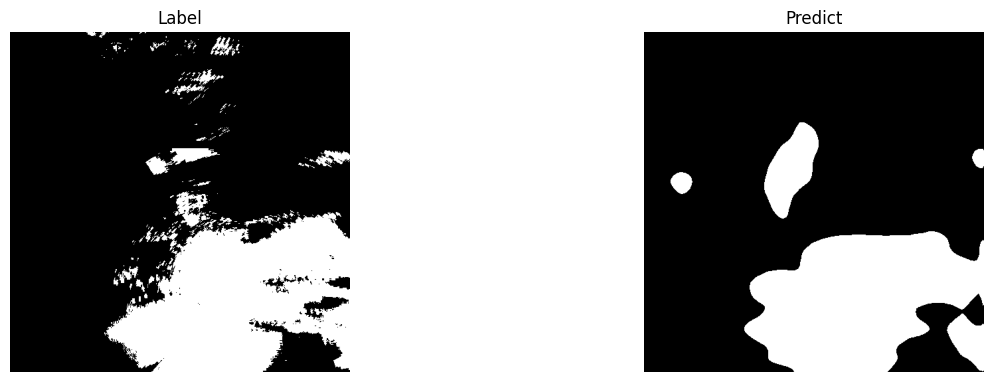

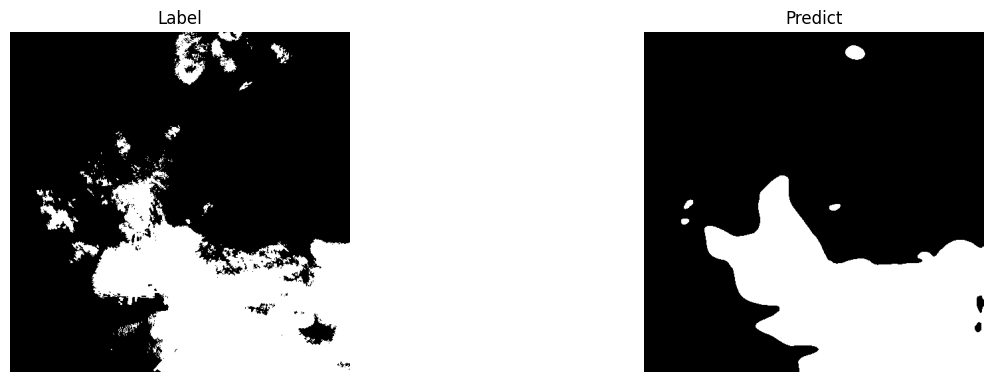

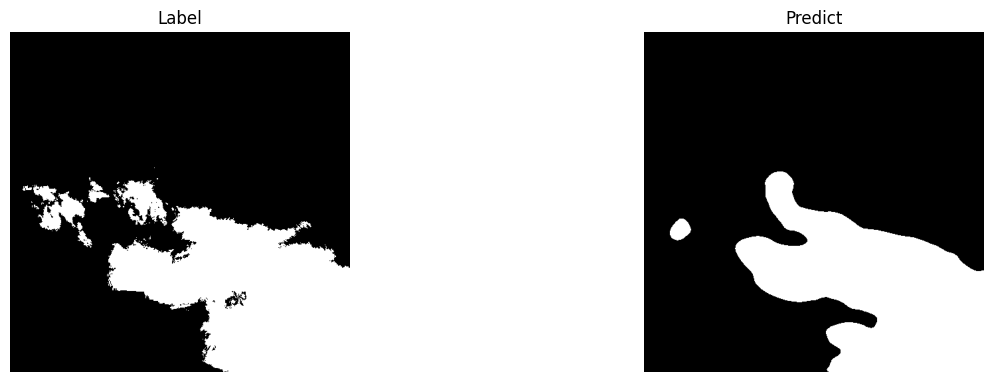

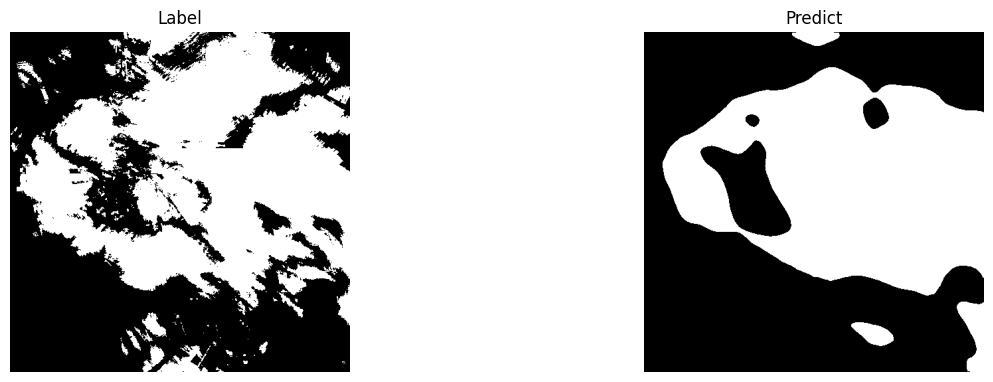

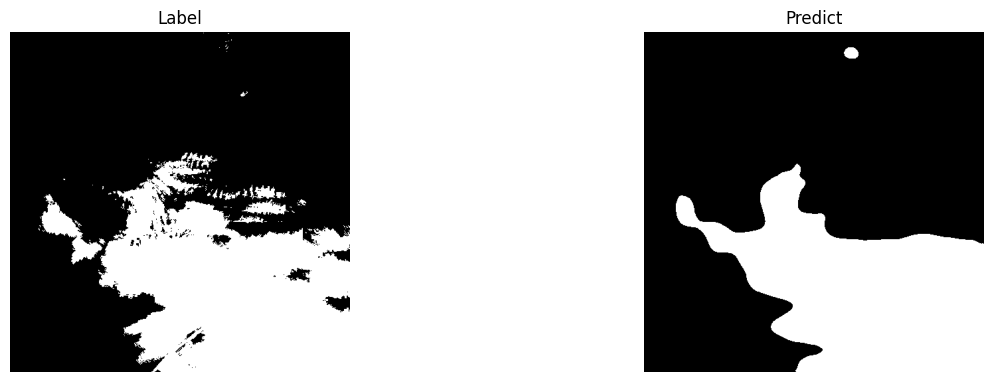

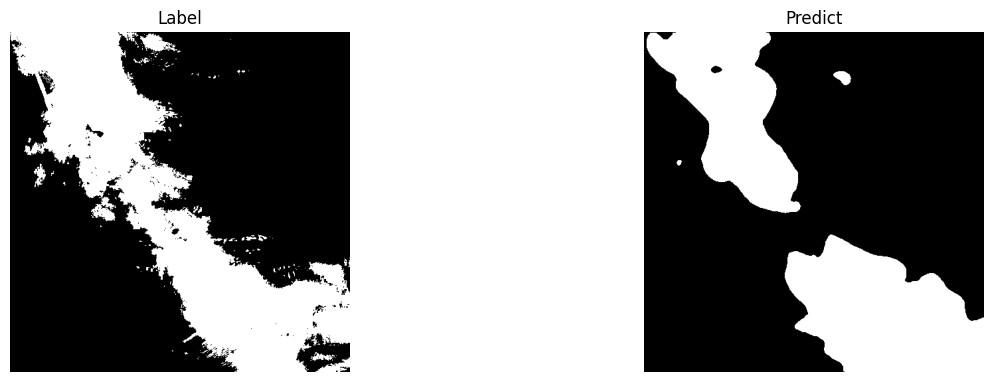

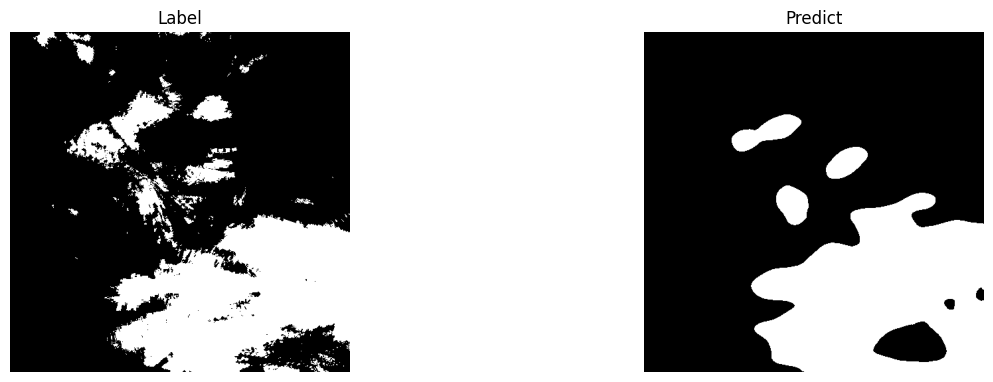

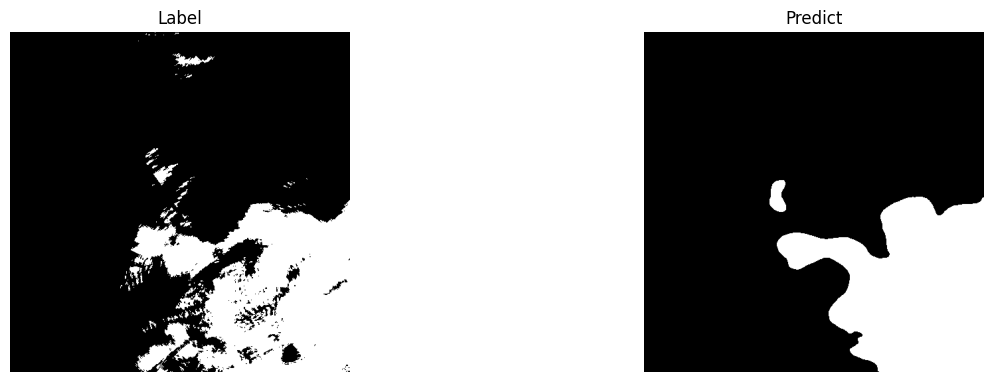

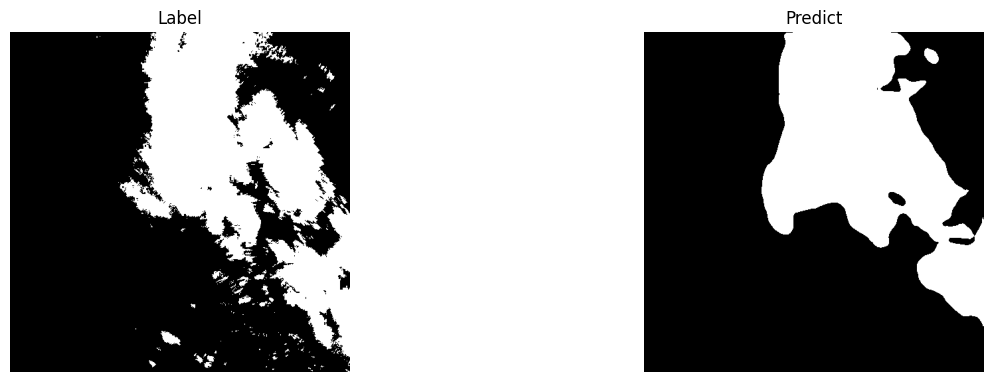

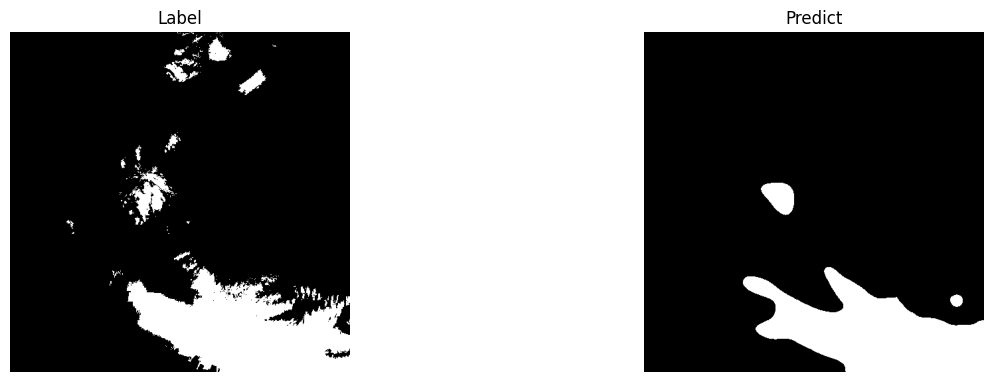

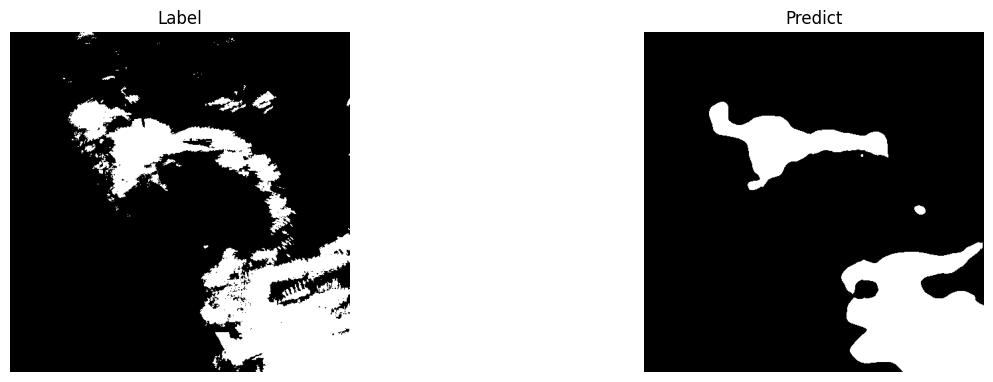

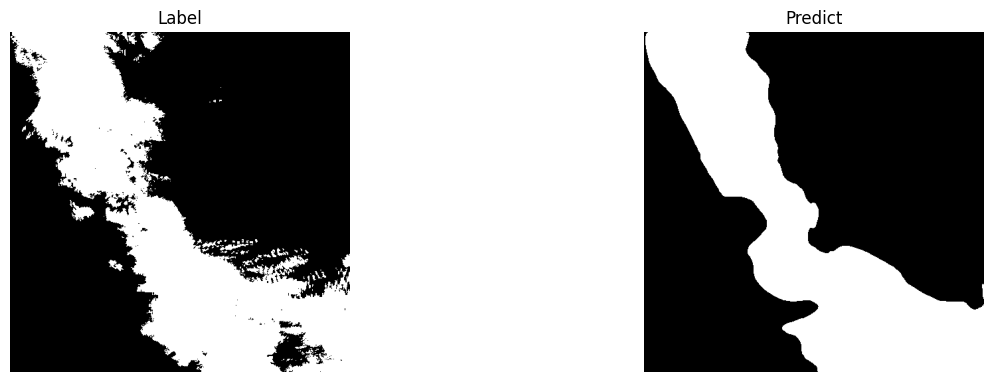

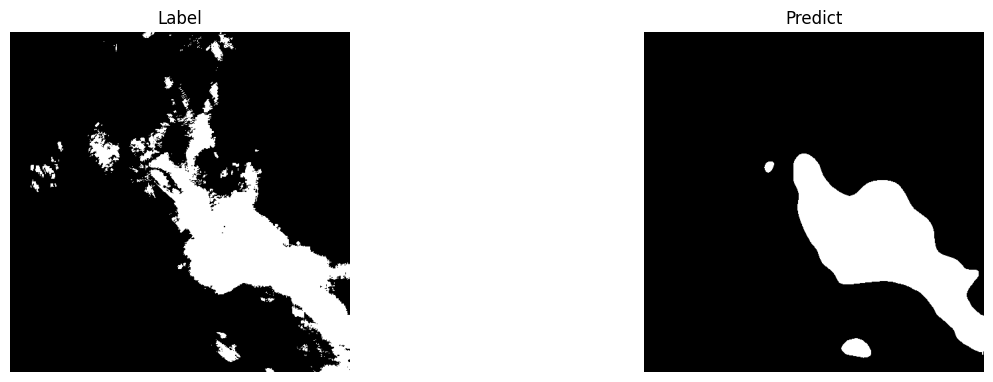

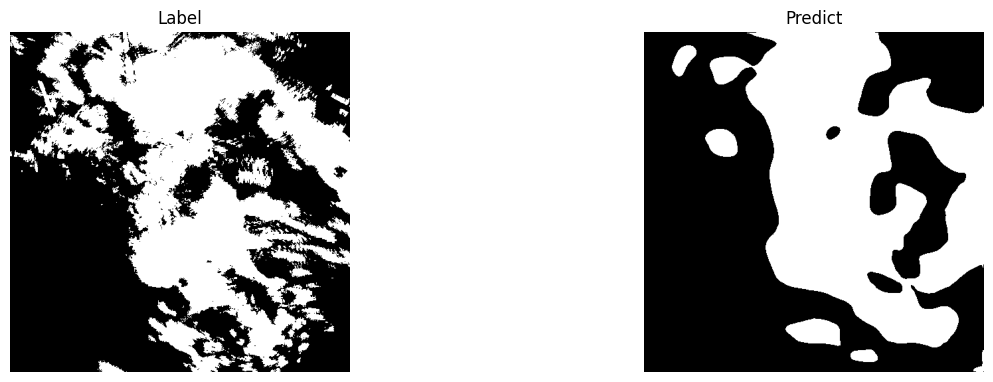

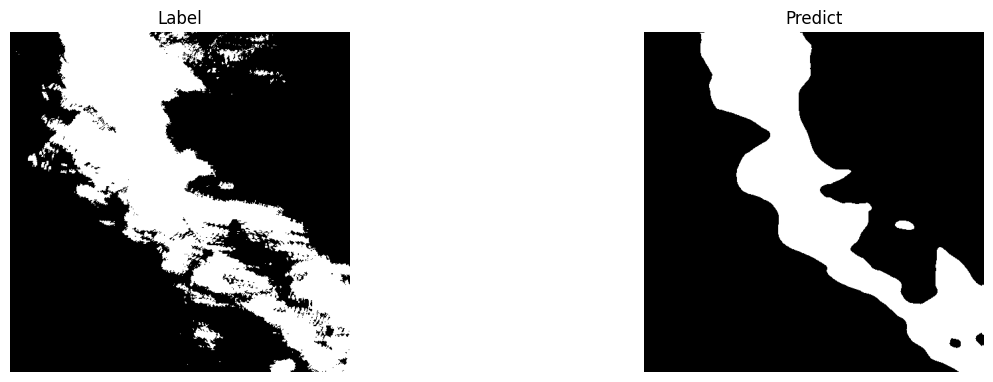

In [ ]:
for i in range(13):
  for j in range(batch_size):
    target_img = tensor_to_img(target[i][j].double())
    pred_img = tensor_to_img(pred[i][j])
    plot(target_img, pred_img)

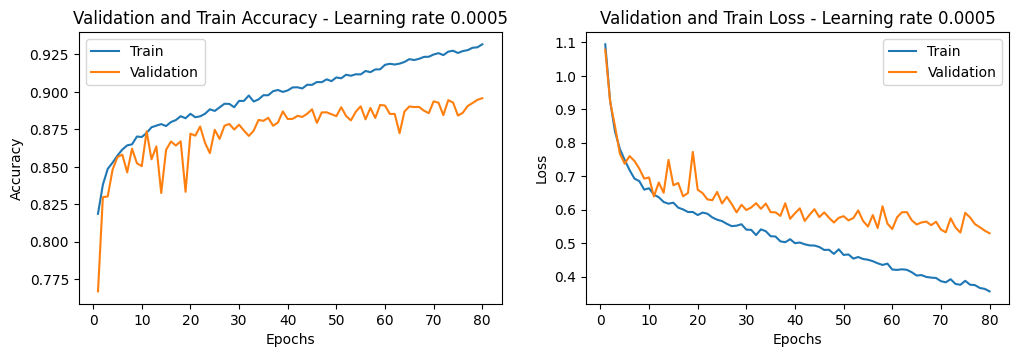

In [ ]:
fig = plt.figure(figsize=(12, 12))

fig.add_subplot(3, 2, 2 * 0 + 1)
plt.title("Validation and Train Accuracy - Learning rate {}".format(lr))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Train")
plt.plot(range(1, len(train_acc) + 1), val_acc, label="Validation")
# plt.xticks(np.arange(1, len(train_acc) + 1, 1.0))
plt.legend()

fig.add_subplot(3, 2, 2 * 0 + 2)
plt.title("Validation and Train Loss - Learning rate {}".format(lr))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1, len(train_acc) + 1), train_losses, label="Train")
plt.plot(range(1, len(train_acc) + 1), val_losses, label="Validation")
# plt.xticks(np.arange(1, len(train_acc) + 1, 1.0))
plt.legend()

plt.show()